### DATU SAGATAVOŠANA

In [ ]:
# BrambleXu. aspect term extraction. Tiešsaiste. GitHub: 11.09.2018. Pieejams: https://github.com/BrambleXu/aspect-term-extraction/tree/master. [skatīts 2025-03-23].

def soup2dict(sentence_nodes):
    sentences = []
    i = 0
    for n in sentence_nodes:
        i += 1
        sentence = {}
        aspect_term = []
        sentence['id'] = i
        sentence['text'] = n.find('text').string
        if n.find('Opinions'):
            for c in n.find('Opinions').contents:
                if c.name == 'Opinion':
                    if c['target'] not in aspect_term:
                        aspect_term.append(c['target'])

        sentence['aspect'] = aspect_term
        sentences.append(sentence)

    return sentences

In [ ]:
def split2words(s_text):
    s_text = re.sub('([.,!?()])', r' \1 ', s_text) # match the punctuation characters and surround them by spaces,
    s_text = re.sub('\s{2,}', ' ', s_text)         # collapse multiple spaces to one space
    words = s_text.lower().split()
    return words

In [ ]:
def tagging_IOB(s, aspects):
    tags = ['O'] * len(s)

    for aspect in aspects:
        pre_index = 0
        for word in s:
            if word in aspect: # 'good' in 'a good place'
                cur_index = s.index(word)
                if cur_index - pre_index == 1: # inside an aspect term
                    tags[cur_index] = 'I'
                else:                       # beginning of an aspect term
                    tags[cur_index] = 'B'
                pre_index = cur_index
    return tags

In [ ]:
def dict2df(sentences):
    data_frames = []
    data = pd.DataFrame()
    for s in sentences:
        sentence = {}
        sentence['Sentence #'] = s['id']
        sentence['Word'] = split2words(s['text'])  # split text to words
        s_length = len(sentence['Word']) # the length of sentence, used to generate tag
        if len(s['aspect'])==0: # tagging: if no aspect term
            sentence['Tag'] = ['O'] * s_length
        else:                                               # IOB format tag if aspect exist
            aspect_terms = [x.lower() for x in s['aspect']]
            sentence['Tag'] = tagging_IOB(sentence['Word'], aspect_terms)

        sentence_df = pd.DataFrame(sentence)
        data_frames.append(sentence_df)

    data = pd.concat(data_frames, ignore_index=True)
    return data

In [ ]:
def read_data(file_path):
    # 1 raw data to soup
    soup = None
    with open(file_path, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f.read().strip(), "lxml-xml")
    if soup is None:
        raise Exception("Can't read xml file")
    sentence_nodes = soup.find_all("sentence")

    # 2  convert soup object to a list of dictionaries
    sentences = soup2dict(sentence_nodes)

    # 3 list to dataframe
    data = dict2df(sentences)

    return data

In [ ]:
from google.colab import files
import re
import numpy as np
import pandas as pd
from pathlib import Path
from bs4 import BeautifulSoup
# OpenAI. ChatGPT o3-mini-high. Uzvedne: izmaini šo koda gabalu tā, lai tas darbotos google colab vidē https://chatgpt.com/ [izmantots 2025-03-23]
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
data = read_data(file_name)
data.tail()

Saving LVtestGOLD_1.xml to LVtestGOLD_1.xml


,Sentence #,Word,Tag
7269,658,iekļauts,O
7270,658,michelin,O
7271,658,restorānu,O
7272,658,ceļvedī,O
7273,658,!,O


In [ ]:
save_file = Path('test.csv')
data.to_csv(save_file, index=False)

### LSTM UN BILSTM APMĀCĪŠANA

In [ ]:
# BrambleXu. aspect term extraction. Tiešsaiste. GitHub: 11.09.2018. Pieejams: https://github.com/BrambleXu/aspect-term-extraction/tree/master. [skatīts 2025-03-23].
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from pathlib import Path
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [ ]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [ ]:
data = data_train
# Save all words as a list
words = list(set(data['Word'].values))
n_words = len(words)

tags = list(set(data["Tag"].values))
n_tags = len(tags)

max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
n_words = len(word2idx)
# word2idx['<unk>'] = len(word2idx) + 1
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx['<pad>'] = 0
n_tags = len(tag2idx) # Due to <pad>, here total tag number is from 17 to 18

In [ ]:
# Sentence class
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
#                                                            s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences # get all sentences

# Word2inx & Padding for X
X = [[word2idx[w[0]] for w in s] for s in sentences]
X_train = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

# Word2inx & Padding for y
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)

# Get one-hot labels
y_train = [to_categorical(i, num_classes=n_tags) for i in y]

print(tag2idx)
print(len(X_train))
print(len(y_train))

{'I': 1, 'O': 2, 'B': 3, '<pad>': 0}
2000
2000


<ipython-input-27-49621940d6e8>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


In [ ]:
# OpenAI. ChatGPT o3-mini-high. Uzvedne: kā var ieviest manā kodā klašu svarus? https://chatgpt.com/ [izmantots 2025-03-26]
y_train = np.array(y_train)
y_train_int = np.argmax(y_train, axis=-1)
class_weight_dict_idx = {
    tag2idx['O']: 1.0,
    tag2idx['I']: 10.0,
    tag2idx['B']: 10.0
}
print(tag2idx)

import numpy as np
sample_weight = np.ones((y_train_int.shape[0], y_train_int.shape[1]), dtype='float32')
for i in range(y_train_int.shape[0]):
    for j in range(y_train_int.shape[1]):
        cls_idx = y_train_int[i,j]
        if cls_idx in class_weight_dict_idx:
            sample_weight[i,j] = class_weight_dict_idx[cls_idx]
        else:
            sample_weight[i,j] = 0.0


{'I': 1, 'O': 2, 'B': 3, '<pad>': 0}


In [ ]:
# GeeksforGeeks. Long short-term memory (LSTM) RNN in Tensorflow. Tiešsaiste. GeeksforGeeks: 25.02.2025. Pieejams: https://www.geeksforgeeks.org/long-short-term-memory-lstm-rnn-in-tensorflow/. [skatīts 2025-03-23].

# OpenAI. ChatGPT o3-mini-high. Uzvedne: par pamatu ņēmu kodu no šī avota (https://github.com/BrambleXu/aspect-term-extraction/blob/master/notebooks/bi-lstm-crf.ipynb).
# ko vari ieteikt, lai varētu uzlabot manu kodu? jo modelis arī apmācās ļoti lēni, salīdzinājumā ar github repositorija autora rezultātiem, un metriku rezultāti manā
# gadījumā arī ir zemi https://chatgpt.com/ [izmantots 2025-03-24]

input_layer = Input(shape=(max_len,))
model = Embedding(input_dim=len(word2idx) + 1,
                  output_dim=200,
                  input_length=max_len,
                  mask_zero=True,
                  trainable=True)(input_layer)
model = LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)
model = Model(input_layer, out)
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"], run_eagerly=True)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 75)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 75, 200)   │  1,052,200 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 75)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 75, 128)   │    168,448 │ embedding_1[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 75, 4)     │        516 │ lstm_1[0][0],     │
│ (TimeDistributed)   │                   │            │ not_equal_1[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,221,164 (4.66 MB)

 Trainable params: 1,221,164 (4.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# OpenAI. ChatGPT o3-mini-high. Uzvedne: tagad nepieciešams sagatavot kodu ar BiLSTM algoritmu, es tev iedošu savu tagadējo kodu ar tagadējiem rezultātiem, nepieciešamības
# pēc veic labojumus un sniedz ieteikumus https://chatgpt.com/ [izmantots 2025-03-27]
input_layer = Input(shape=(max_len,))
model = Embedding(input_dim=len(word2idx) + 1,
                  output_dim=300,
                  input_length=max_len,
                  mask_zero=True)(input_layer)
model = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1))(model)
model = Dropout(0.2)(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)
model = Model(input_layer, out)
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"], run_eagerly=True)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 75)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 75, 300)   │  1,578,300 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 75)        │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 75, 256)   │    439,296 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 75, 256)   │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 75, 4)     │      1,028 │ dropout_3[0][0],  │
│ (TimeDistributed)   │                   │            │ not_equal_4[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,018,624 (7.70 MB)

 Trainable params: 2,018,624 (7.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.1778 - loss: 2.5369 - val_accuracy: 0.1839 - val_loss: 1.5216
Epoch 2/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.1510 - loss: 1.7325 - val_accuracy: 0.1623 - val_loss: 1.1469
Epoch 3/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.1464 - loss: 1.0804 - val_accuracy: 0.1762 - val_loss: 0.9920
Epoch 4/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.1546 - loss: 0.7709 - val_accuracy: 0.1791 - val_loss: 1.0018
Epoch 5/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.1590 - loss: 0.5546 - val_accuracy: 0.1800 - val_loss: 1.0192
Epoch 6/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.1609 - loss: 0.4783 - val_accuracy: 0.1802 - val_loss: 1.0957
Epoch 7/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.1612 - loss: 0.4019 - val_accuracy: 0.1806 - val_loss: 1.1632
Epoch 8/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.1602 - loss: 0.3252 - val_accuracy: 0.1732 - val_l

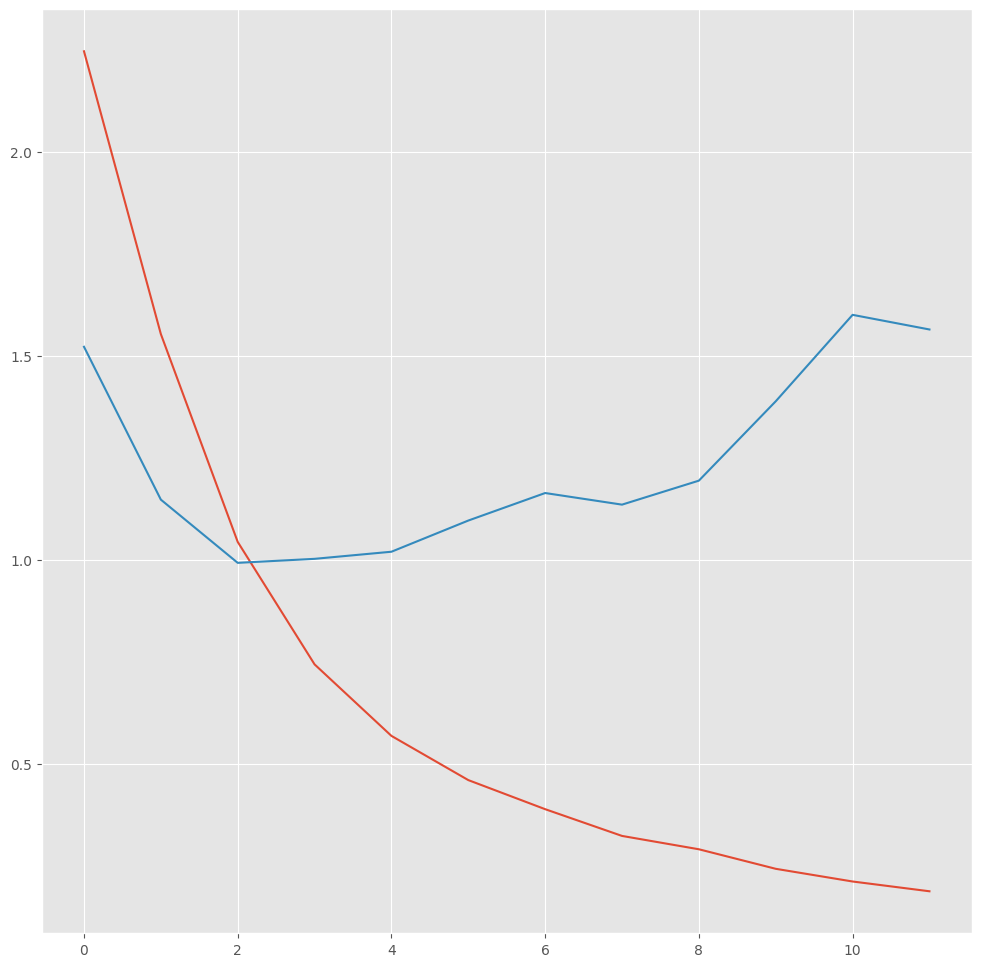

In [ ]:
history = model.fit(X_train, np.array(y_train), batch_size=64, epochs=12,
                    validation_split=0.1, sample_weight=sample_weight, verbose=1)
hist = pd.DataFrame(history.history)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

### LSTM UN BILSTM PĀRBAUDĪŠANA

In [ ]:
data = data_test
getter = SentenceGetter(data)
sentences = getter.sentences # get all sentences

# Word2inx & Padding for X
X = [[word2idx.get(w[0], 0) for w in s] for s in sentences]
X_test = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

# Word2inx & Padding for y
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx['<pad>'])

# Get one-hot labels
y_test = [to_categorical(i, num_classes=n_tags) for i in y]

<ipython-input-27-49621940d6e8>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


In [ ]:
print(sentences[1])
print(X_test[1])
print(np.argmax(y_test[1], -1))

[('ļoti', 'O'), ('draudzīgas', 'O'), ('cenas', 'O'), ('ēdieniem', 'B'), ('un', 'O'), ('laba', 'O'), ('vietējā', 'O'), ('alus', 'B'), ('izlase', 'I'), ('.', 'O')]
[3046    0 4148 1924 2048 3896  539 1602 2440 1231    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[2 2 2 3 2 2 2 3 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


In [ ]:
# Predictions.
idx2word = {value: key for key, value in word2idx.items()}
idx2tag = {value: key for key, value in tag2idx.items()}
print(idx2tag)

{1: 'I', 2: 'O', 3: 'B', 0: '<pad>'}


In [ ]:
true_all = np.argmax(y_test, -1)
true_all_tags = [[idx2tag[idx] for idx in s if idx!=0] for s in true_all]

p_all = model.predict(np.array(X_test)) # (4796, 75, 18)
p_all= np.argmax(p_all, axis=-1) # (4796, 75)
p_all_tags = [[idx2tag[idx] for idx in s] for s in p_all] # ['B-gpe', 'O', 'O', 'O']

for i, true in enumerate(true_all_tags):
    length = len(true)
    p_all_tags[i] = p_all_tags[i][:length]

p_all_tags = [[x.replace('<pad>', 'O') for x in s] for s in p_all_tags]

print(sentences[3])
print(X_test[3])
print(true_all_tags[3])
print(p_all_tags[3])

21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 918ms/step
[('perfekta', 'O'), ('apkalpošana', 'I'), (',', 'O'), ('prot', 'O'), ('ieteikt', 'O'), ('lieliskus', 'O'), ('ēdienus', 'O'), ('.', 'O')]
[1151 5142  993    0  245    0 1687 1231    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
['O', 'I', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
# OpenAI. ChatGPT o3-mini-high. Uzvedne: kā man izlabot kļūdu ValueError: max() arg is an empty sequence šajā koda daļā? https://chatgpt.com/ [izmantots 2025-03-26]
# OpenAI. ChatGPT o3-mini-high. Uzvedne: šo kodu es izmantoju modeļa apmācīšanai ar datu kopu, kas ir paredzēta noskaņojumu noteikšanai aspektiem.
# CSV faili sastāv no teikuma numura, vārda un marķiera, kas apzīmē šī vārda noskaņojumu (2 - pozitīvs, 1 - neitrāls, 0 - negatīvs, O - nav noskaņojuma) https://chatgpt.com/ [izmantots 2025-03-26]
from sklearn.metrics import classification_report

true_flat = []
pred_flat = []
for i in range(len(true_all_tags)):
    true_flat.extend(true_all_tags[i])
    pred_flat.extend(p_all_tags[i])

print(classification_report(true_flat, pred_flat, labels=["B","I","O"]))


              precision    recall  f1-score   support

           B       0.37      0.62      0.46       459
           I       0.26      0.29      0.27       217
           O       0.97      0.92      0.94      6598

    accuracy                           0.88      7274
   macro avg       0.53      0.61      0.56      7274
weighted avg       0.91      0.88      0.89      7274

